https://levelup.gitconnected.com/gaussian-mixture-models-gmm-816f549940c5

In [66]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm

In [136]:
import sklearn

In [73]:
from sklearn.mixture.gaussian_mixture import BaseMixture

There are a few @abstractmethod in the BaseMixture class. abstract methods are placeholders and MUST be defined in the derived class.

In [133]:
class GMM1D(BaseMixture):
    """
    1D = n_feature = 1
    """
    
    def __init__(self, n_components, max_iter=100, covariance_type = 'full'):
        """
        covariance_type == "full" meaning all gaussians have independent mu and var.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.covariance_type = covariance_type
        
    def _initialize(self, X, resp):
        self.pi = [1/self.n_components for comp in range(self.n_components)]
        
    def fit(self, X):
        new_X = np.array_split(X, self.n_components)
        # Initial computation of mean and covar
        self.means_ = [np.mean(x, axis=0) for x in new_X]
        self.covariances_ = [np.var(x) for x in new_X]        
        del new_X
        
        resp = np.zeros((len(X),self.n_components))
        self._initialize(X, resp)
        for iteration in range(self.max_iter):
            # E-step
            
            for i in range(self.n_components):
                g = norm(loc=self.means_[i], scale=self.covariances_[i])
                resp[:,i] = self.pi[i]*g.pdf(X[:])

            for i in range(len(resp)):
                resp[i,:] /= np.sum(resp[i,:])

            # M-step
            self._m_step(X, resp)
            
    def _m_step(self, X, resp):
        # 'means_' attrbute of scipy.GMM class is list. But...
        #for k in range(self.n_components):
        #    for n in range(len(X)):
        #        self.means_[k] += resp[n,k] * X[n]
        #        self.means_ = [1/N[k]*self.means_[k] for k in range(self.n_components)]
        
        mc = np.sum(resp, axis=0)
        self.pi = mc/len(X)
        # update means_
        self.means_ = np.sum(resp*np.tile(X, [self.n_components,1]).T, axis=0)/mc
        self.covariances_ = []
        for c in range(len(self.pi)):
            self.covariances_.append(np.sum(np.dot(resp[:,c]*(X[i] - self.means_[c]).T,
                                                 resp[:,c]*(X[i] - self.means_[c])))/mc[c])
    
    def score_samples(self, X):
        """Compute the weighted log probabilities for each sample.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log probabilities of each data point in X.
        """
        check_is_fitted(self)
        X = _check_X(X, None, self.means_.shape[1])

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def score(self, X, y=None):
        """Compute the per-sample average log-likelihood of the given data X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_dimensions)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_likelihood : float
            Log likelihood of the Gaussian mixture given X.
        """
        return self.score_samples(X).mean()
            
    def _n_parameters(self):
        """Return the number of free parameters in the model."""
        n_features = 1
        if self.covariance_type == 'full':
            cov_params = self.n_components * n_features * (n_features + 1) / 2.
        #elif self.covariance_type == 'diag':
        #    cov_params = self.n_components * n_features
        #elif self.covariance_type == 'tied':
        #    cov_params = n_features * (n_features + 1) / 2.
        #elif self.covariance_type == 'spherical':
        #    cov_params = self.n_components
        mean_params = n_features * self.n_components
        return int(cov_params + mean_params + self.n_components - 1)
    
    def bic(self, X):
        """Bayesian information criterion for the current model on the input X.
        Parameters
        ----------
        X : array of shape (n_samples, n_dimensions)
        Returns
        -------
        bic : float
            The lower the better.
        """
        return (-2 * self.score(X) * X.shape[0] +
                self._n_parameters() * np.log(X.shape[0]))

    def aic(self, X):
        """Akaike information criterion for the current model on the input X.
        Parameters
        ----------
        X : array of shape (n_samples, n_dimensions)
        Returns
        -------
        aic : float
            The lower the better.
        """
        return -2 * self.score(X) * X.shape[0] + 2 * self._n_parameters()
    
    def _estimate_log_prob(self, X):
        return _estimate_log_gaussian_prob(
            X, self.means_, self.precisions_cholesky_, self.covariance_type)
    
    def _check_parameters(self):
        """
            fake
        """
        pass
    
    def _get_parameters(self):
        """
            I don't think I will use this.. haha..
        """
        return (self.weights_, self.means_, self.covariances__,
                self.precisions_cholesky_)
    def _set_parameters(self, params):
        """
            fake
        """
        pass
     
    def _estimate_log_weights(self):
        return np.log(self.weights_)

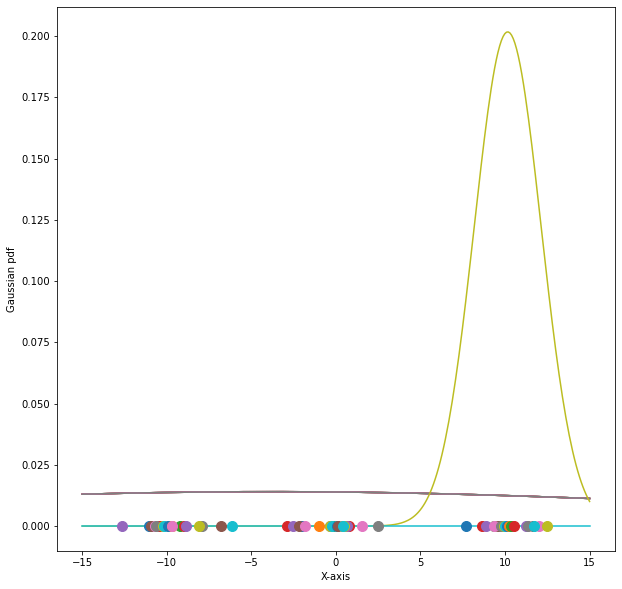

In [135]:
# Test

x = np.linspace(-5,5,20)
x1 = x*np.random.rand(20)
x2 = x*np.random.rand(20)*1.1 - 10
x3 = x*np.random.rand(20)*0.6 + 10

# All data
xt = np.hstack((x1,x2,x3))


gmm = GMM1D(10)
gmm.fit(xt)
#gmm = GMM1d(xt, 50)
#gmm.run()
#gmm = mixture.GaussianMixture(n_components = 3, 
#         covariance_type = 'full', max_iter = 50)
#gmm.fit(xt[:,np.newaxis])
Gs = []
#for mu, var in zip(gmm.means_, gmm.var_vector):
for mu, var in zip(gmm.means_, gmm.covariances_):
    Gs.append(norm(loc=mu, scale=var.squeeze()))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i in range(len(xt)):
    ax.scatter(xt[i],0,s=100)
    
for g in Gs:
    ax.plot(np.linspace(-15,15,300),g.pdf(np.linspace(-15,15,300)),zorder=0)
    
ax.set_xlabel('X-axis')
ax.set_ylabel("Gaussian pdf")

plt.show()


## At some point in the code occurs numerical errors (zero division?)
sklearn implementation performs computation in log?

## build GMM mask

In [69]:
#!/usr/bin/env python3

# Application of the Gaussian Mixture Model 
# to find the right threshould level for segmentation,  
# finding the target in the central image of astronomical data, and
# producing the mask for the target.
# Developed by Min-Su Shin (msshin@kasi.re.kr)

import sys, math

from astropy.io import fits
from sklearn import mixture
#from skimage import measure
#from skimage.morphology import convex_hull_image
import matplotlib.pyplot as plt
import numpy as np

from astrobf.utils.gmm import *

# some parameters
max_n_comp = 30
max_iter_gmm = 300
tol_gmm = 0.0001
range_cut_min = 0.1
range_cut_max = 95.0
num_sample_x = 3000

In [70]:
# Load image
fits_fn = "../example_data/J000311.00+155754.0-i.fits"
hdulist = fits.open(fits_fn)
img_header = hdulist[0].header
img_data = hdulist[0].data
hdulist.close()
width=img_data.shape[0]
height=img_data.shape[1]
img_data_1d = img_data.reshape(-1, 1)
num_pixels = width * height

In [71]:
# Criteria to determine the number of components.
# Note that these criteria don't tell you what's the best model, just the number of components.

bic_list = [] # Bayesian Information Critetion
aic_list = [] # Akaike Information Criterion
aicc_list = [] # corrected Akaike Information Criterion
model_list = []
for n_comp in range(1, max_n_comp+1):
    #gmm = mixture.GaussianMixture(n_components = n_comp, 
    #     covariance_type = 'full', tol = tol_gmm, max_iter = max_iter_gmm)
    gmm = GMM1D(n_components = n_comp, max_iter = max_iter_gmm)
    model = gmm.fit(img_data_1d)
    model_list.append(model)
    bic_list.append(gmm.bic(img_data_1d))
    aic = gmm.aic(img_data_1d)
    aic_list.append(aic)
    aicc_list.append(gmm_aicc(aic, gmm._n_parameters(), num_pixels))

plot_gmm_statstics(max_n_comp, bic_list, aic_list, aicc_list)

best_n_comp, best_val = get_best_gmm(aic_list)

print("... best_n_comp: ", best_n_comp, " with criteria val: ", best_val)

AttributeError: 'GMM1D' object has no attribute 'bic'